In [1]:
import pickle
from viz import plot_UAV_FLPO, plot_UAV_FLPO_3D, plot_uavFLPO_with_routes
import torch
import Animator
import uavFLPO
from DatasetGenerator import torchFLPO_2_numpyFLPO 
import utils
import importlib
from pathlib import Path
from SPN import SPN
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from inference import inference


In [2]:
torch.cuda.empty_cache()
model_classes = {"SPN": SPN}
weights_address = (
    Path("Saved_models") /
    "FT100_FastAnneal_2025_07_19_01_50_51.pth"
)
spn = utils.load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in spn.parameters():
    param.requires_grad = False
print("SPN loaded on: ", spn.device)

Model created.
SPN loaded on:  cpu


### Plot the results of high (or low) beta solution


-------Optimization Info-------

beta:	100
final_cost:	0.115
Grad_norm:	0.001
optim_method:	sampling_GD_at_beta_auto_diff
optim_iters:	1000
optim_step:	0.01
optim_tol:	0.001


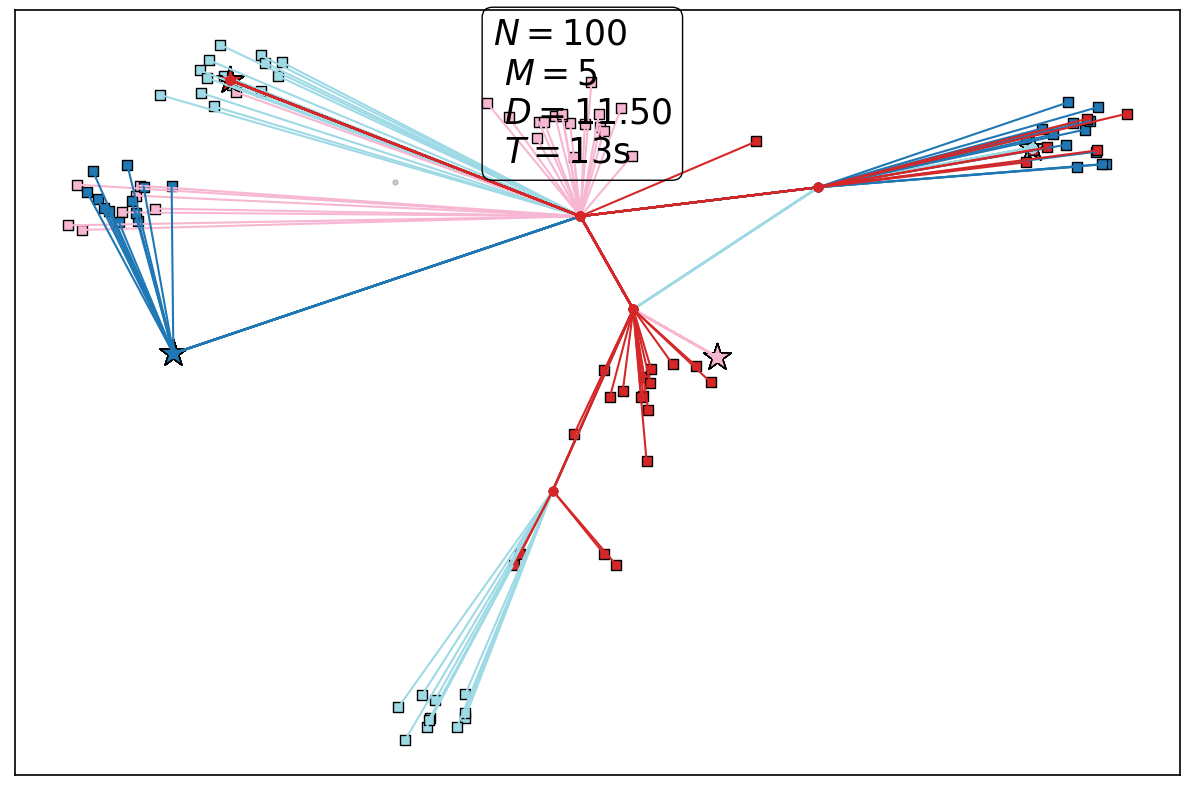

In [4]:
file_path0 = "AAAI26_res/high_beta_res/N100_M5_ends4_seed3"

with open(file_path0, 'rb') as file:
    high_beta_data = pickle.load(file)

START_locs = high_beta_data["START_locs"]
END_locs = high_beta_data["END_locs"]
F_base_sampling = high_beta_data["F_base0"]
# n_path_samples = high_beta_data['n_path_samples']
beta = high_beta_data['beta']
FreeEnergy = high_beta_data['Free_energy_final']
Gradient_norm = torch.norm(high_beta_data['Gradient_final'])
optim_method = high_beta_data['optim_method']
optim_step = high_beta_data['optim_step']
optim_iters = high_beta_data['optim_iters']
optim_tol = high_beta_data['optim_tol']
runtime = high_beta_data['runtime']
finalcost = high_beta_data['Free_energy_final']

print("\n-------Optimization Info-------\n")
print(f"beta:\t{beta}")
# print(f"n_path_samples:\t{n_path_samples}")
print(f"final_cost:\t{FreeEnergy:.3f}")
print(f"Grad_norm:\t{Gradient_norm:.3f}")
print(f"optim_method:\t{optim_method}")
print(f"optim_iters:\t{optim_iters}")
print(f"optim_step:\t{optim_step}")
print(f"optim_tol:\t{optim_tol}")

N = START_locs.shape[0]
F_locs = F_base_sampling.expand(N, -1, -1)  # view, shares grad with F_base
data = torch.cat((START_locs, F_locs, END_locs), dim=1)
# routes = inference(data,spn,"Greedy")[1].squeeze()[:,1:].cpu().numpy()
routes = utils.generate_true_labels(data,1000)[1][:,1:]
plot_uavFLPO_with_routes(
    START_locs, 
    END_locs, 
    F_base_sampling,
    final_cost=finalcost,
    runtime=runtime, 
    routes=routes,
    cmap_name="tab20", 
    fraction_to_plot=1.0,
    textcoords = [0.41,0.99], 
    textsize=25,
    random_seed=0,
    save_path=file_path0 + ".png")
    


-------Optimization Info-------

beta array:	[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
cost_array:	[-2564.640625, -256.1901550292969, -25.341737747192383, -2.2636380195617676, -0.024062857031822205, 0.11568022519350052, 0.11657946556806564, 0.11660024523735046]
n_path_samples:	8
optim_method:	sampling_auto_diff
optim_iters:	100
optim_step:	0.01
optim_tol:	0.001


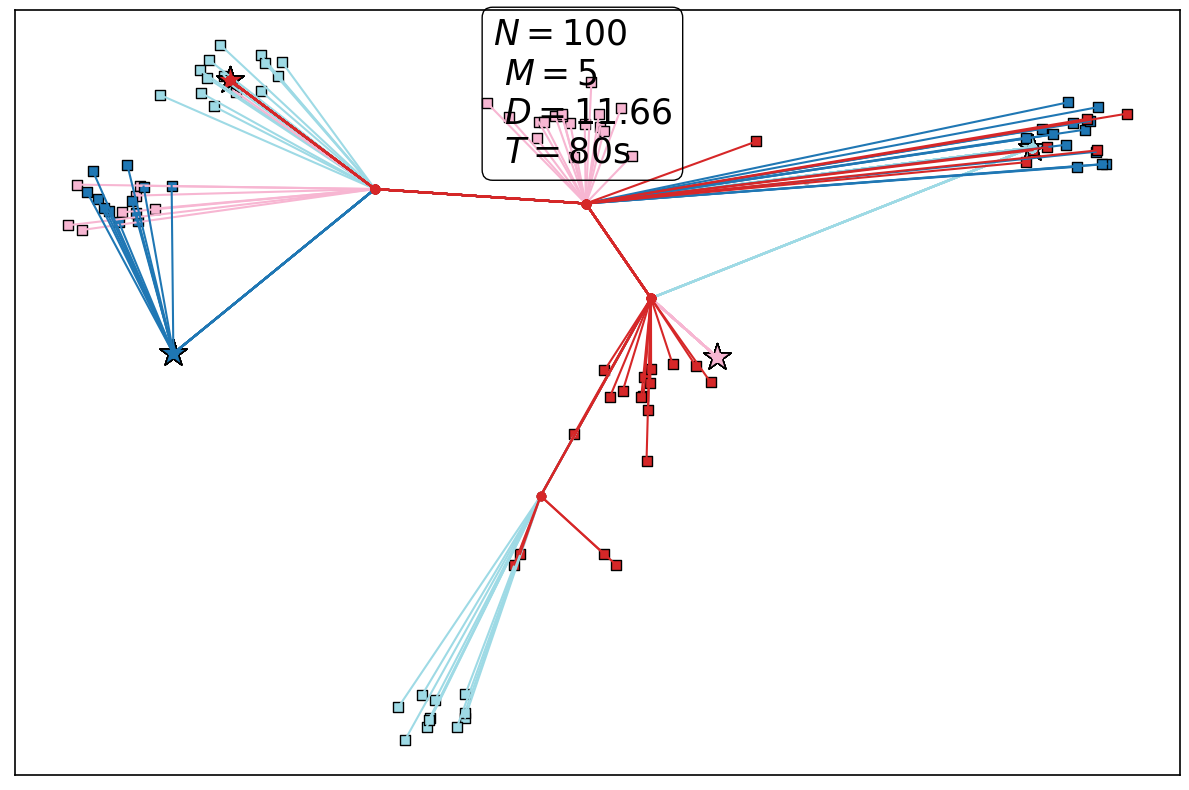

In [5]:
file_path1 = "AAAI26_res/annealing_res/N100_M5_ends4_seed3"

with open(file_path1, 'rb') as file:
    annealing_res_data = pickle.load(file)

START_locs1 = annealing_res_data['START_locs']
END_locs1 = annealing_res_data['END_locs']
Y_arr = annealing_res_data['Y_arr']
n_path_samples = annealing_res_data['n_path_samples']
b_arr = annealing_res_data['b_arr']
F_arr = annealing_res_data['F_arr']
optim_method = annealing_res_data['optim_method']
optim_step = annealing_res_data['optim_step']
optim_iters = annealing_res_data['optim_iters']
optim_tol = annealing_res_data['optim_tol']
runtime = annealing_res_data['runtime']

print("\n-------Optimization Info-------\n")
print(f"beta array:\t{b_arr}")
print(f"cost_array:\t{F_arr}")
print(f"n_path_samples:\t{n_path_samples}")
print(f"optim_method:\t{optim_method}")
print(f"optim_iters:\t{optim_iters}")
print(f"optim_step:\t{optim_step}")
print(f"optim_tol:\t{optim_tol}")

# routes = calc_routs_uavFLPO(START_locs1, END_locs1, Y_arr[-1])
N = START_locs.shape[0]
F_locs1 = Y_arr[-1].expand(N, -1, -1)  # view, shares grad with F_base
data = torch.cat((START_locs1, F_locs1, END_locs1), dim=1)
# routes = inference(data,spn,"Greedy")[1].squeeze()[:,1:].cpu().numpy()
routes = utils.generate_true_labels(data,1000)[1][:,1:]
plot_uavFLPO_with_routes(
    START_locs1, 
    END_locs1, 
    Y_arr[-1], 
    final_cost=F_arr[-1],
    runtime=runtime, 
    routes=routes, 
    fraction_to_plot=1.0,
    textcoords = [0.41,0.99], 
    textsize=25,
    random_seed=0
    , save_path=file_path1 + ".png")

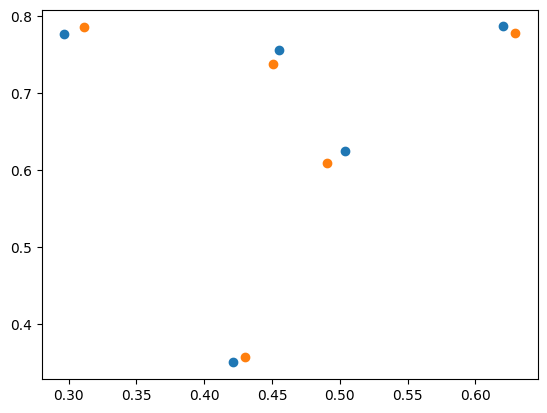

In [6]:
from matplotlib import pyplot as plt
plt.scatter(Y_arr[-1][0,:,0].cpu().numpy(), Y_arr[-1][0,:,1].cpu().numpy())
plt.scatter(F_base_sampling[0,:,0].detach().cpu().numpy(), F_base_sampling[0,:,1].detach().cpu().numpy())

### Plot Annealing Snaps for different beta values

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

start_locs = START_locs1.cpu().numpy().reshape(-1, 2)
end_locs = END_locs1.cpu().numpy().reshape(-1, 2)

figuresize = (18, 4)
facecolor = "#FFFFFF"
edgecolor = "#000000"

# UAV-wise color mapping
num_uavs = start_locs.shape[0]
cmap = plt.get_cmap("tab20", num_uavs)
uav_colors = [cmap(i) for i in range(num_uavs)]

subplot_indices = [0, 3, 4, -1]
fig = plt.figure(figsize=figuresize)

for i, idx in enumerate(subplot_indices):
    ax = plt.subplot(1, len(subplot_indices), i + 1)
    
    f_locs = Y_arr[idx].detach().cpu().numpy().squeeze()

    # Plot each UAV's start and end in same color
    for j in range(num_uavs):
        plt.scatter(start_locs[j, 0], start_locs[j, 1], marker='s', color=uav_colors[j], alpha=0.1)
        plt.scatter(end_locs[j, 0], end_locs[j, 1], marker='X', color=uav_colors[j], s=200)

    # Plot facilities
    plt.scatter(f_locs[:, 0], f_locs[:, 1], color="black", marker="o", label=rf'$\beta$={b_arr[idx]:.3e}')

    # Clean plot: no ticks, keep border
    plt.xticks([])
    plt.yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.2)

    plt.text(0.05,0.95,rf"$\beta={b_arr[idx]:.1e}$",fontsize=20,color='black')

# Create a common legend
legend_elements = [
    Line2D([], [], marker='s', color='w', label='Start', markerfacecolor='purple', markersize=10, alpha=0.4),
    Line2D([], [], marker='X', color='w', label='End', markerfacecolor='red', markersize=15),
    Line2D([], [], marker='o', color='black', label='Facility', linestyle='None', markersize=8)
]

# Place the legend below all subplots, centered
fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=3,
    fontsize=24,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make space for the legend
plt.show()


# Save annealing animations

In [ ]:
# file_path2 = "AAAI26_res/annealing_res/animate_N200_M50_ends4_seed3.gif"

# Animator.animate_UAV_FLPO(
#     START_locs,
#     END_locs,
#     Y_arr,
#     figuresize=(6, 5),
#     interval=200,
#     save_path=file_path2,
# )


In [ ]:
# file_path3 = "AAAI26_res/annealing_res/3Danimate_N200_M50_ends4_seed3.gif"

# Animator.animate_UAV_FLPO_3D(
#         START_locs,
#         END_locs,
#         Y_arr,
#         start_altitudes=None,
#         end_altitudes=None,
#         facility_heights_list=None,
#         scene_title="UAV Spatial Deployment Over Time",
#         output_gif=file_path3,
#         frame_duration=100,
#         render_timeout=30,
#         camera = (0.3,0.7,2.0)
#     )
